In [54]:
import os
import re
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score


from sklearn.model_selection import train_test_split

In [55]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64

In [56]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, data_dir, selected_bands, transform=None):
        self.images_paths=sorted(glob(os.path.join(data_dir, 'images', '*.tif')))
        self.masks_paths=sorted(glob(os.path.join(data_dir, 'masks', '*.png')))

        self.masks_paths =[
            path for path in self.masks_paths
            if re.fullmatch(r'.*/\d+\.png', path)
        ]

        assert len(self.images_paths) == len(self.masks_paths), "Image and mask count mismatch"

        self.selected_bands=selected_bands
        self.transform=transform


    def __len__(self):
        return len(self.images_paths)

    def normalize(self, image):
        for b in range(image.shape[0]):
            band = image[b]
            min_val = band.min()
            max_val = band.max()
            image[b] = (band - min_val) / (max_val - min_val + 1e-8)
        return image

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]

        image = tifffile.imread(img_path).astype(np.float32)
        image = image[:, :, self.selected_bands]
        image = np.transpose(image, (2, 0, 1))
        image = self.normalize(image)

        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)

        image_tensor = torch.tensor(image, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return image_tensor, mask_tensor

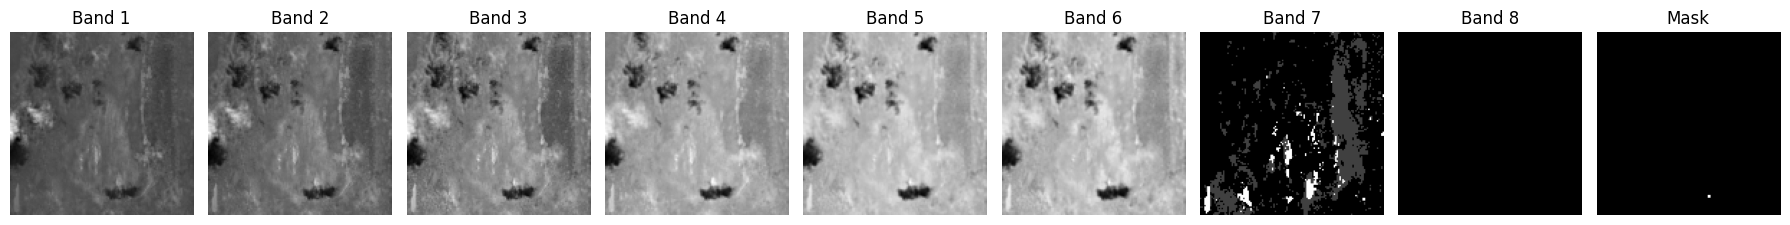

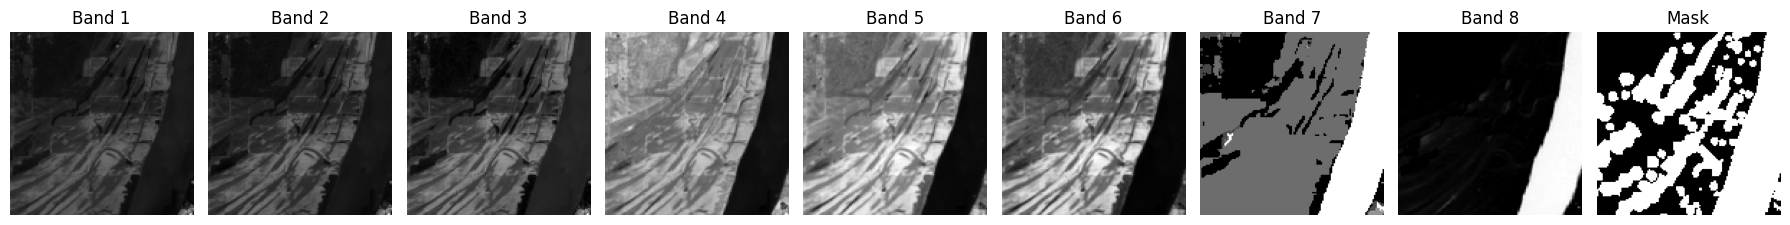

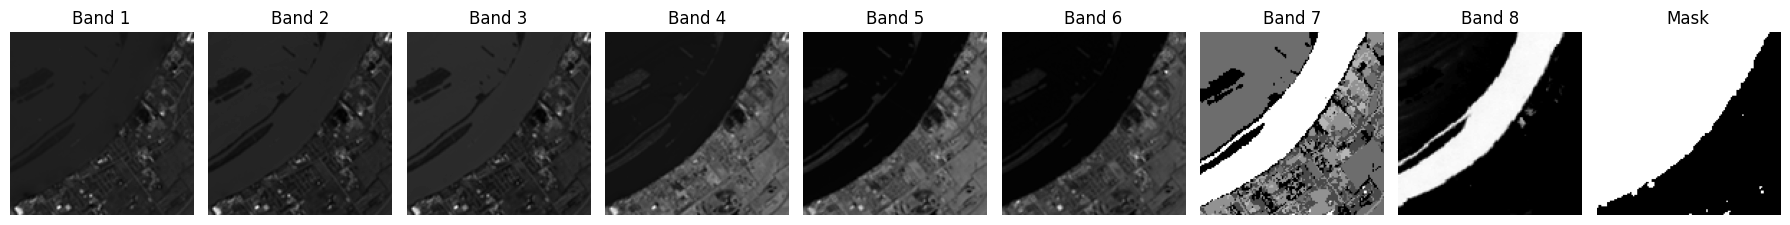

In [57]:
selected_bands = [i for i in range(12) if i not in (0, 7, 8, 9)]
data_dir = '/kaggle/input/water-data/data'
dataset = WaterSegmentationDataset(data_dir, selected_bands)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

for imgs, masks in train_loader:
    for i in range(3):
        image = imgs[i]
        mask = masks[i]
        
        fig, axes = plt.subplots(1, 8 + 1, figsize=(2 * (8 + 1), 3))
        for b in range(image.shape[0]):
            ax = axes[b]
            ax.imshow(image[b, :, :].cpu(), cmap='gray')
            ax.set_title(f"Band {b + 1}")
            ax.axis('off')
        
        ax = axes[8]
        ax.imshow(mask.cpu(), cmap='gray')
        ax.set_title("Mask")
        ax.axis('off')

        plt.tight_layout()
        plt.show()
            
    break

In [58]:
def createDeepLabv3(input_channels=8, output_channels=1):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    
    old_conv = model.backbone.conv1
    new_conv = nn.Conv2d(
        input_channels,
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=old_conv.bias is not None
    )

    with torch.no_grad():
        new_conv.weight[:, :3] = old_conv.weight 
        if input_channels > 3:
            mean_weight = old_conv.weight[:, :3].mean(dim=1, keepdim=True)
            for i in range(3, input_channels):
                new_conv.weight[:, i:i+1] = mean_weight

    model.backbone.conv1 = new_conv

    model.classifier = DeepLabHead(2048, output_channels)
    
    return model

In [59]:
model = createDeepLabv3()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1).float()
        
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [61]:
def compute_metrics(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).int().cpu().numpy().reshape(-1)
    targets = targets.int().cpu().numpy().reshape(-1)

    f1 = f1_score(targets, preds, zero_division=1)
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    accuracy = (preds == targets).sum() / len(targets)
    iou = jaccard_score(targets, preds, zero_division=1)

    return f1, precision, recall, accuracy, iou

In [62]:
def train_one_epoch(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    all_metrics = []

    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        outputs = model(imgs)['out']
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_metrics.append(compute_metrics(outputs.detach(), masks))

    avg_metrics = np.mean(all_metrics, axis=0)
    return total_loss / len(loader), avg_metrics


def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    all_metrics = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            outputs = model(imgs)['out']
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()

            all_metrics.append(compute_metrics(outputs, masks))

    avg_metrics = np.mean(all_metrics, axis=0)
    return total_loss / len(loader), avg_metrics


In [63]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": [],
    "train_iou": [],
    "val_iou": [],
    "train_acc": [],
    "val_acc": [],
}

model = createDeepLabv3().to(DEVICE)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    train_loss, train_metrics = train_one_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_metrics = validate(model, val_loader, loss_fn)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"    F1: {train_metrics[0]:.4f} | Precision: {train_metrics[1]:.4f} | Recall: {train_metrics[2]:.4f} | Acc: {train_metrics[3]:.4f} | IoU: {train_metrics[4]:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"    F1: {val_metrics[0]:.4f} | Precision: {val_metrics[1]:.4f} | Recall: {val_metrics[2]:.4f} | Acc: {val_metrics[3]:.4f} | IoU: {val_metrics[4]:.4f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    history["train_f1"].append(train_metrics[0])
    history["val_f1"].append(val_metrics[0])
    
    history["train_iou"].append(train_metrics[4])
    history["val_iou"].append(val_metrics[4])

    history["train_acc"].append(train_metrics[3])
    history["val_acc"].append(val_metrics[3])

Epoch 1/30
  Train Loss: 0.5323
    F1: 0.5833 | Precision: 0.4663 | Recall: 0.8137 | Acc: 0.6587 | IoU: 0.4188
  Val Loss:   0.6901
    F1: 0.5198 | Precision: 0.6161 | Recall: 0.4495 | Acc: 0.8189 | IoU: 0.3511
Epoch 2/30
  Train Loss: 0.3661
    F1: 0.7254 | Precision: 0.6388 | Recall: 0.8406 | Acc: 0.8297 | IoU: 0.5721
  Val Loss:   0.6567
    F1: 0.6533 | Precision: 0.7568 | Recall: 0.5746 | Acc: 0.8670 | IoU: 0.4851
Epoch 3/30
  Train Loss: 0.3129
    F1: 0.7526 | Precision: 0.6529 | Recall: 0.8943 | Acc: 0.8443 | IoU: 0.6037
  Val Loss:   0.5771
    F1: 0.7264 | Precision: 0.8179 | Recall: 0.6533 | Acc: 0.8927 | IoU: 0.5703
Epoch 4/30
  Train Loss: 0.2778
    F1: 0.7900 | Precision: 0.6975 | Recall: 0.9111 | Acc: 0.8695 | IoU: 0.6531
  Val Loss:   0.4872
    F1: 0.7461 | Precision: 0.8050 | Recall: 0.6952 | Acc: 0.8968 | IoU: 0.5950
Epoch 5/30
  Train Loss: 0.2686
    F1: 0.8014 | Precision: 0.7151 | Recall: 0.9154 | Acc: 0.8815 | IoU: 0.6695
  Val Loss:   0.4290
    F1: 0.7597 

In [64]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Val F1")
    plt.title("F1 Score")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_iou"], label="Train IoU")
    plt.plot(epochs, history["val_iou"], label="Val IoU")
    plt.title("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()


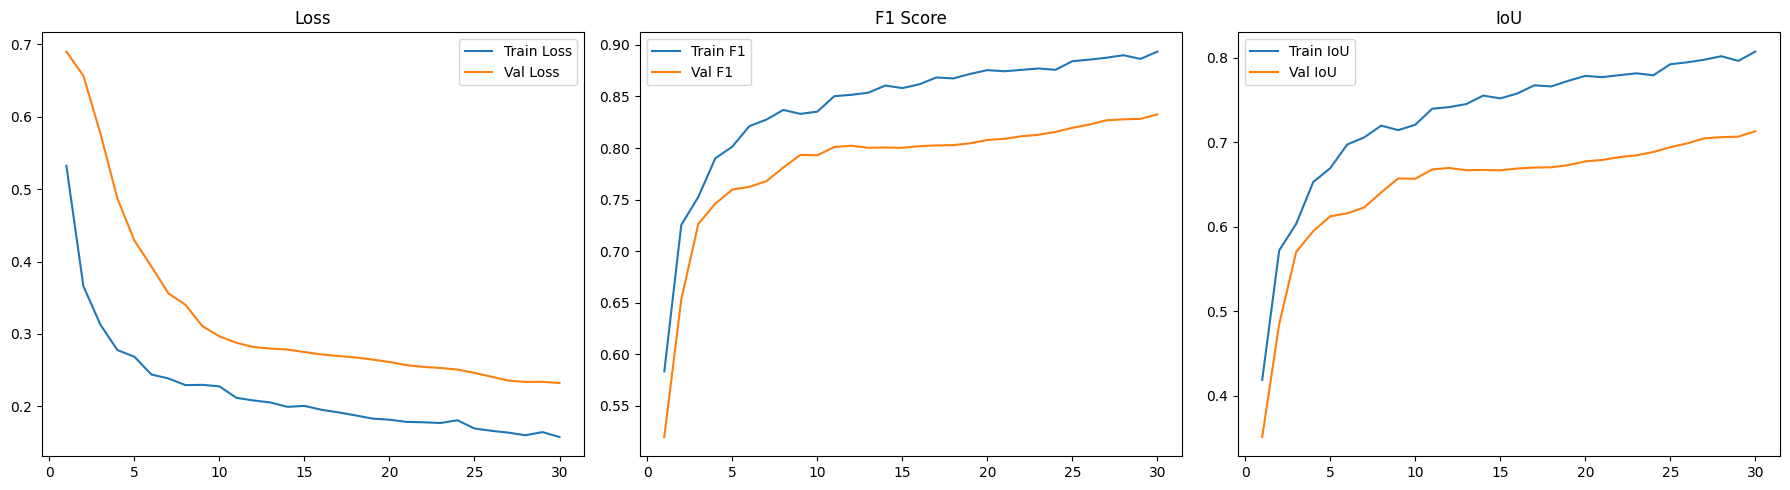

In [65]:
plot_training_history(history)

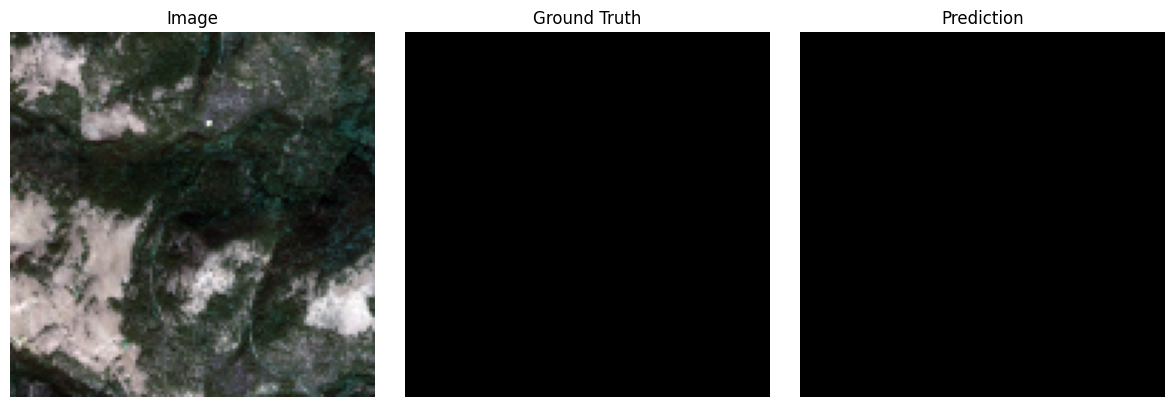

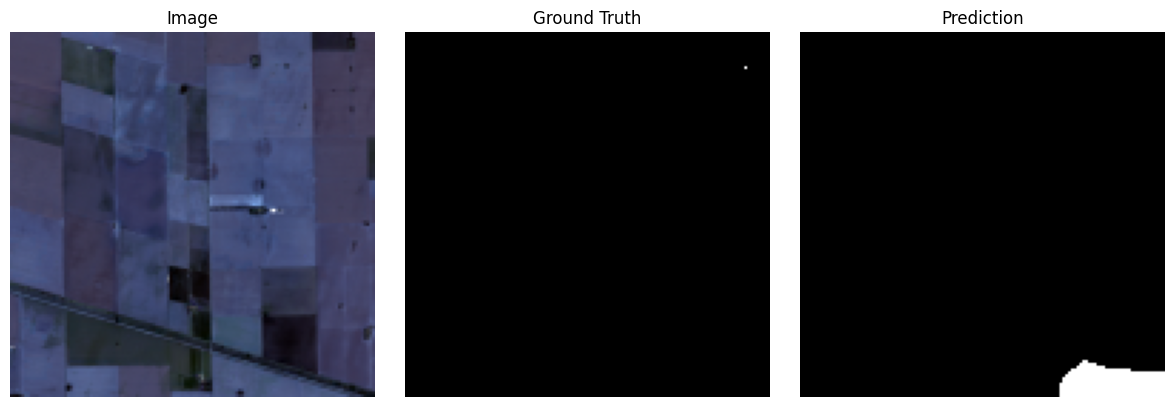

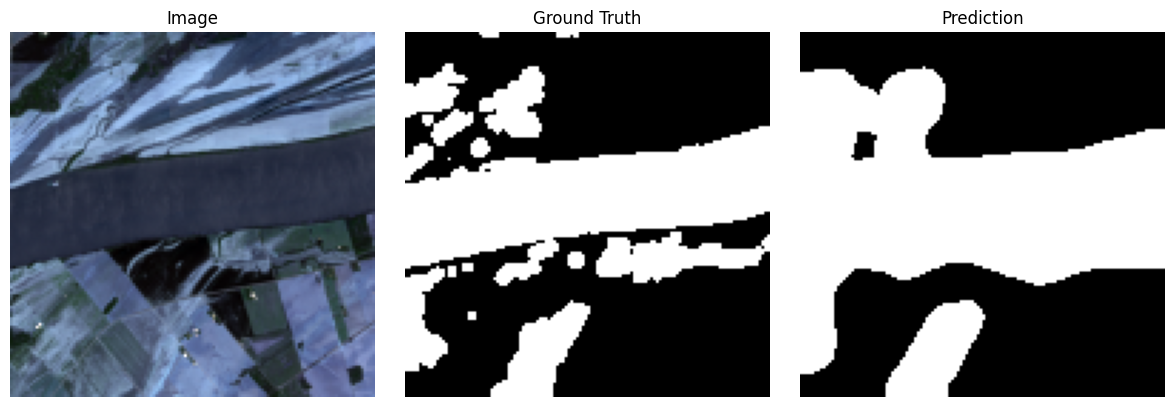

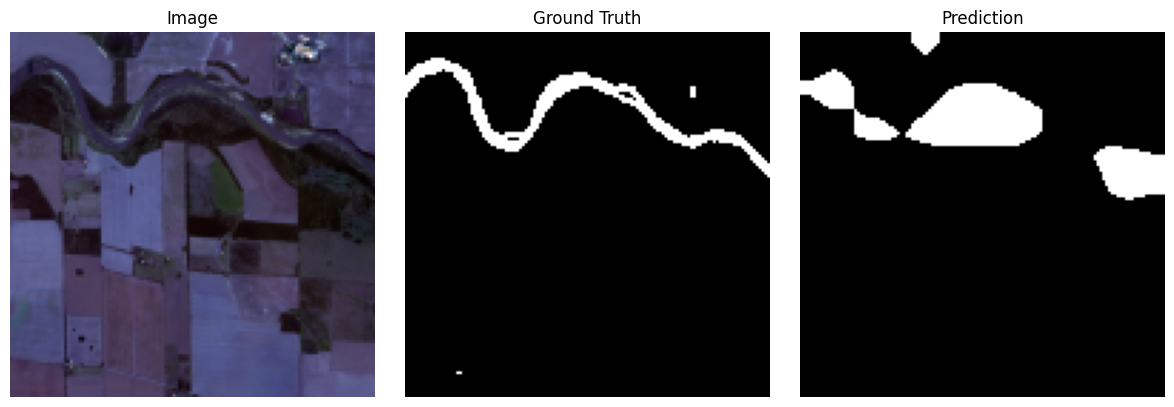

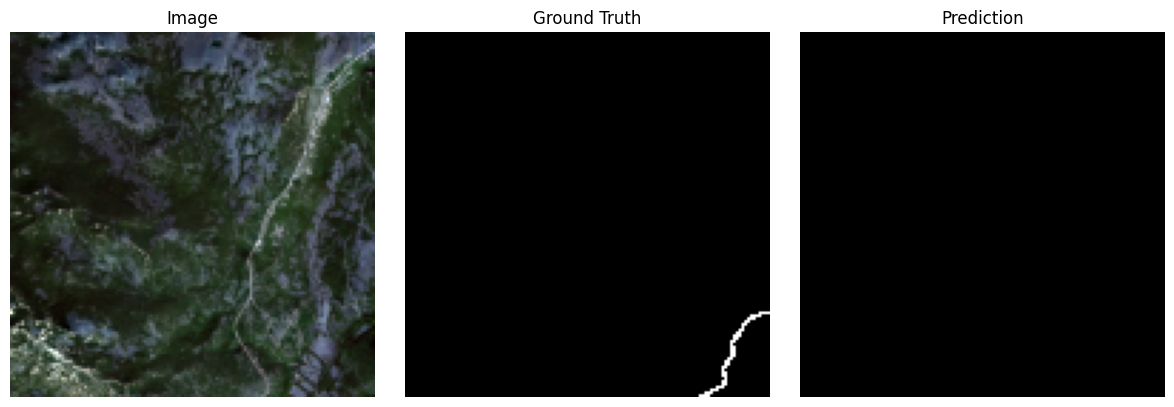

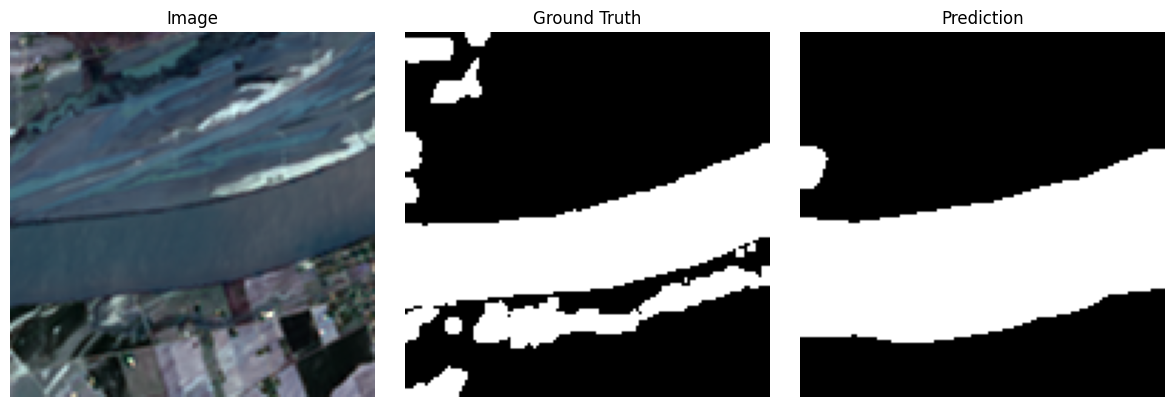

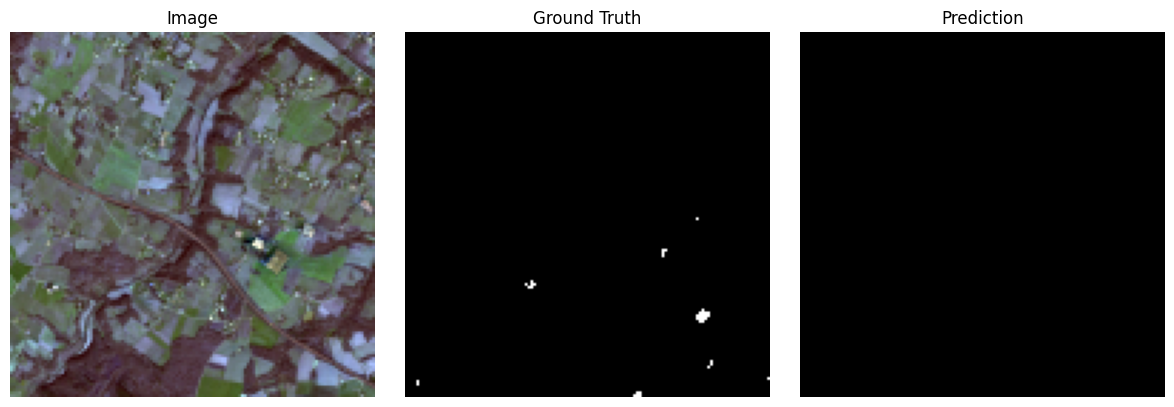

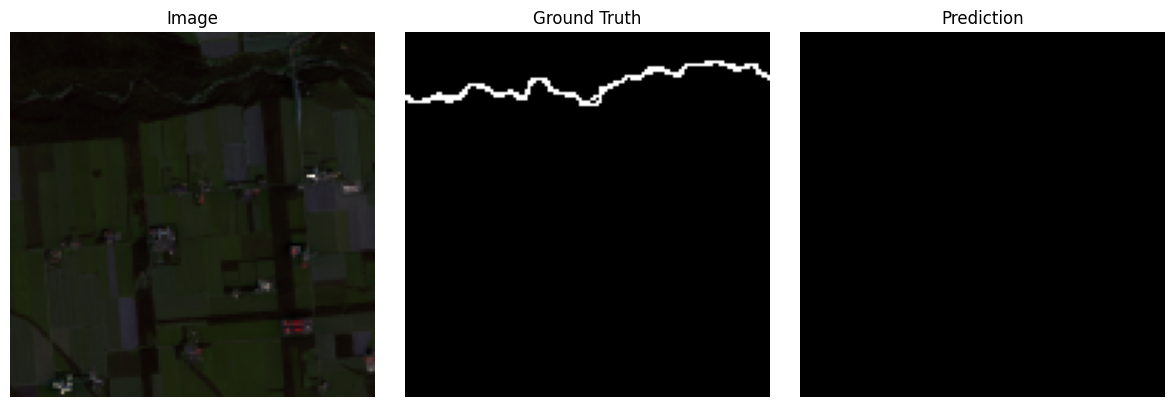

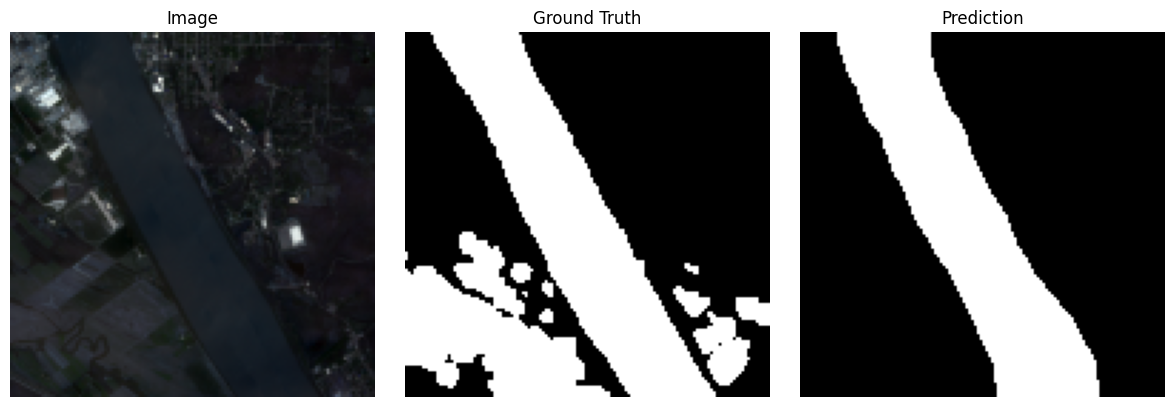

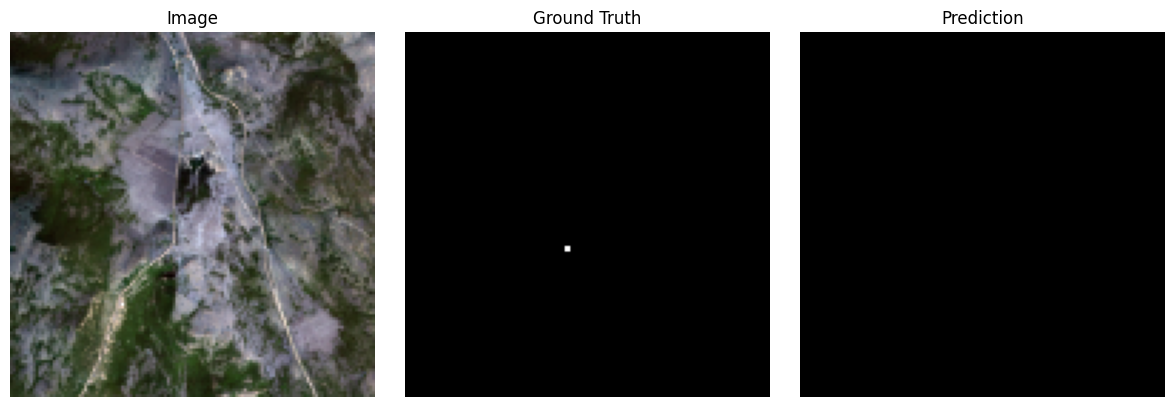

In [74]:
def visualize_predictions(model, dataloader, num_samples=10):
    model.eval()
    count = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)['out']
            preds = torch.sigmoid(outputs).cpu().numpy()
            imgs = imgs.cpu().numpy()
            masks = masks.cpu().numpy()

            batch_size = imgs.shape[0]
            for i in range(50, batch_size):
                if count >= num_samples:
                    return

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                if imgs.shape[1] >= 3:
                    rgb = imgs[i][:3]
                    rgb = np.transpose(rgb, (1, 2, 0))
                    axs[0].imshow(rgb)
                    axs[0].set_title("Image")
                else:
                    axs[0].imshow(imgs[i][0], cmap='gray')
                    axs[0].set_title("Image")

                axs[1].imshow(masks[i], cmap='gray')
                axs[1].set_title("Ground Truth")

                axs[2].imshow(preds[i][0] > 0.5, cmap='gray')
                axs[2].set_title("Prediction")

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                count += 1
                
visualize_predictions(model, val_loader, num_samples=10)

In [ ]:
|